# Kaggle: Housing Prices 

In this notebook we explore the [housing prices kaggle challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) with Google Colab.  


This is the second notebook in the housing prices kaggle challenge.  Here we explore Deep Learning techniques for performing the regression.



To begin, we will clone the repo to have access to the kaggle dataset.

In [1]:
!git clone https://github.com/demarley/figment

fatal: destination path 'figment' already exists and is not an empty directory.


## Deep Learning Techniques

Now that we've covered some basic analysis techniques and boosted decision trees, let's explore some deep learning techniques for doing the regression.

To do this, we'll start with `keras+tensorflow` because they are well-supported by Google Colab.  
If there's time, we'll install `pytorch` and try that as well.

In [0]:
# plotting
import matplotlib.style
import matplotlib as mpl
mpl.style.use("default")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd

np.random.seed(2019)

In [0]:
df = pd.read_csv("figment/housing-prices/data/train.csv");

### Data Cleaning 

From the previous notebooks, we know there are changes we can make to the dataset.  For now we won't do those here.  We will just leave the features that are textual alone for the time being. Let's look at the correlation matrix and choose some of the features more correlated with `SalePrice` (of the features that have numerical data).

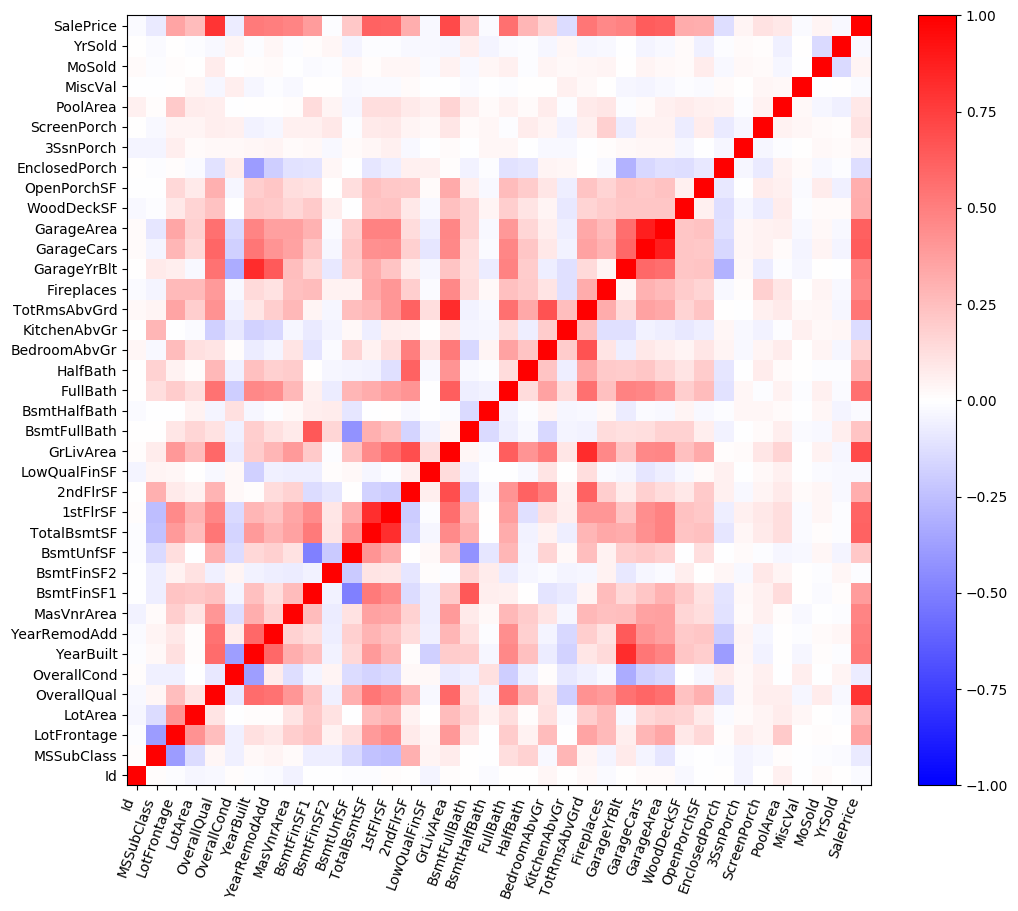

In [4]:
corrmat = df.corr()

fig,ax  = plt.subplots(figsize=(12,10))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(corrmat, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)

labels = corrmat.columns.values

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

From this correlation matrix, let's choose some of the features most strongly correlated with `SalePrice`.  Then, split the data into a `training` and `validation` sets.

This attempt will use a somewhat random pick of features.  We'll just look at features that have correlations greater than 0.25 with `SalePrice`.

In [5]:
strong_corrs = corrmat[np.abs(corrmat.SalePrice)>0.25].SalePrice
features = list(strong_corrs.index)
_ = features.remove("SalePrice")   # remove the target value from the inputs!
print(strong_corrs.sort_values())

LotArea         0.263843
HalfBath        0.284108
OpenPorchSF     0.315856
2ndFlrSF        0.319334
WoodDeckSF      0.324413
LotFrontage     0.351799
BsmtFinSF1      0.386420
Fireplaces      0.466929
MasVnrArea      0.477493
GarageYrBlt     0.486362
YearRemodAdd    0.507101
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64


In [0]:
# split into test and training 
from sklearn.model_selection import train_test_split

df  = df.fillna(-1)
tmp = df.sample(frac=1) # shuffle the dataframe rows
tts = train_test_split(df[features].values,\
                       df['SalePrice'].values, \
                       test_size=0.25)
X_train,X_test,Y_train,Y_test = tts

### Deep Learning with Keras
Using `keras+tensorflow`, let's try to do a more sophisticated prediction.

In this setup, we will only be exploring a multi-layer perceptron.

In [7]:
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import explained_variance_score  # quantifying accuracy of regression

Using TensorFlow backend.


In [0]:
# Hyperparameters
# Initially, I'll just choose some random hyperparameters and will adjust it as needed
n_feats = len(features)
optimizer = 'adam'
loss = 'mse'
metrics = ['mse', 'mae', 'mape']
activation = 'relu'
n_hidden = 1
n_nodes  = 2*n_feats    # considering rectangular models at the moment
validation_split = 0.25
n_epochs = 50

In [0]:
# Define the model
model = Sequential()
model.add(Dense(n_nodes, activation=activation, input_dim=n_feats))

for l in range(n_hidden):
    model.add(Dense(n_nodes, activation=activation))

model.add(Dense(1, activation='linear'))       # Output node
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [0]:
# Fit to the training dataset
history = model.fit(X_train, Y_train, epochs=n_epochs, validation_split=validation_split, verbose=0) # output is large, suppressed it for now

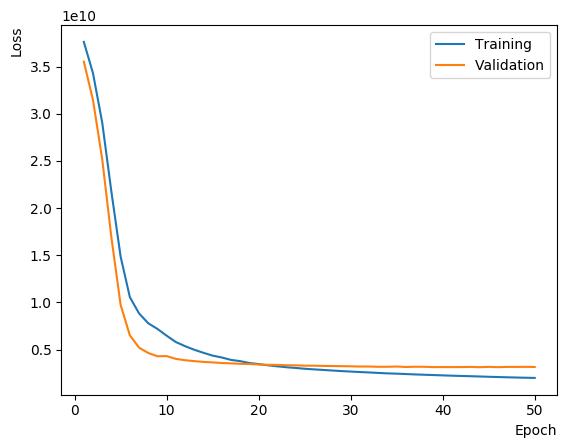

In [27]:
# Plot the loss for training and validation sets
fig,ax = plt.subplots()

loss     = history.history['loss']
val_loss = history.history.get('val_loss')

x = range(1,len(loss)+1)
plt.plot(x,loss,    label='Training')
plt.plot(x,val_loss,label="Validation")

plt.xlabel('Epoch',ha='right',va='top',   position=(1,0))
plt.ylabel('Loss', ha='right',va='bottom',position=(0,1))

plt.legend(loc=0,numpoints=1)

In [0]:
predictions = model.predict(X_test).flatten()
values      = np.divide((np.asarray(predictions) - Y_test),Y_test)        # offsets to compare predicted and actual value

Distribution = 0.086 $\pm$ 0.2739
EV Score     = 0.638


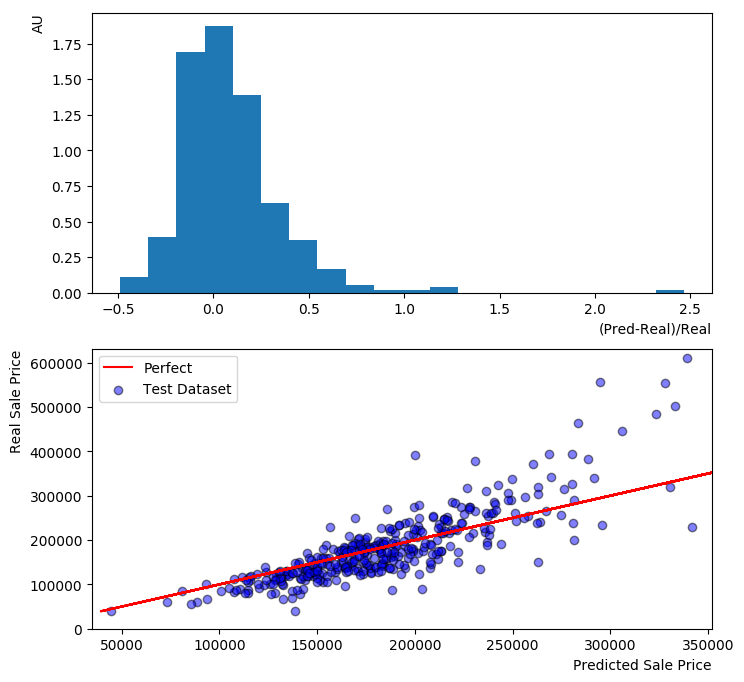

In [29]:
# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

# We can also quantify the output using the function `explained_variance_score` 
# from `scikit-learn` that I just discovered! (I also added it to the other notebooks)
evs = explained_variance_score(Y_test,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

So, as you can see, the predictions are not that great.  Let's modify the hyperparameters and try again.

In [0]:
# Hyperparameters
# Initially, I'll just choose some random hyperparameters and will adjust it as needed
n_feats = len(features)
optimizer = 'adam'
loss = 'mse'
metrics = ['mse', 'mae', 'mape']
activation = 'elu'
n_hidden = 2
n_nodes  = 3*n_feats    # considering rectangular models at the moment
validation_split = 0.25

In [0]:
# Define the model
model = Sequential()
model.add(Dense(n_nodes, activation=activation, input_dim=n_feats))

for l in range(n_hidden):
    model.add(Dense(n_nodes, activation=activation))

model.add(Dense(1, activation='linear'))       # Output node
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [0]:
# Fit to the training dataset
history = model.fit(X_train, Y_train, epochs=n_epochs, validation_split=validation_split, verbose=0) # suppress output for now

In [0]:
predictions = model.predict(X_test).flatten()
values      = np.divide((np.asarray(predictions) - Y_test),Y_test)        # offsets to compare predicted and actual value

Distribution = 0.015 $\pm$ 0.2511
EV Score     = 0.713


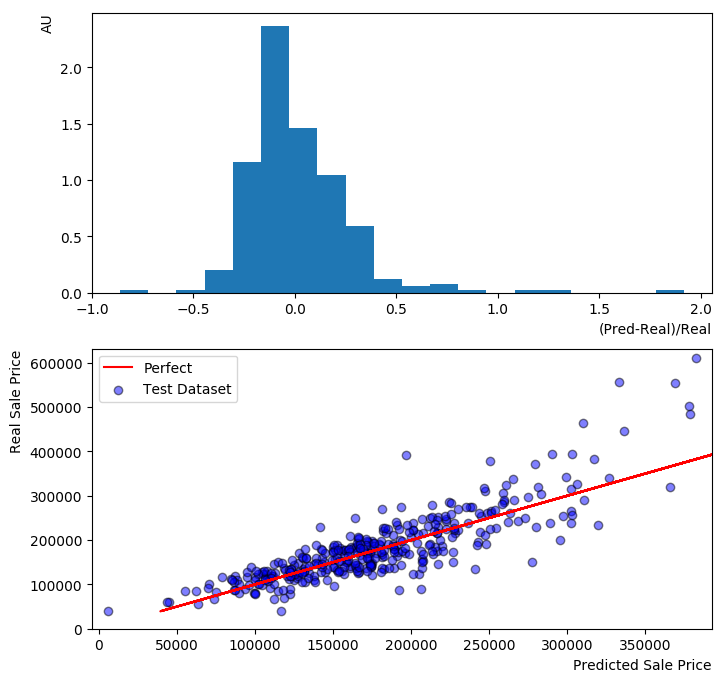

In [49]:
# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

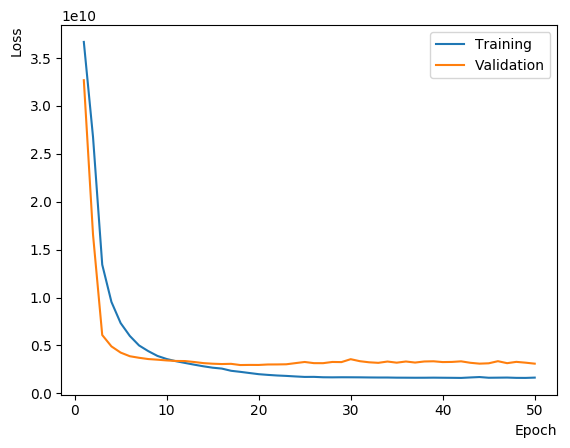

In [50]:
# plot the loss and validation sets vs epoch
fig,ax = plt.subplots()

loss     = history.history['loss']
val_loss = history.history.get('val_loss')

x = range(1,len(loss)+1)
plt.plot(x,loss,    label='Training')
plt.plot(x,val_loss,label="Validation")

plt.xlabel('Epoch',ha='right',va='top',   position=(1,0))
plt.ylabel('Loss', ha='right',va='bottom',position=(0,1))

plt.legend(loc=0,numpoints=1)

By modifying the hyperparameters we're able to do a little better (smaller RMS and larger `evaluation_variance_score`).
However, it does appear that the loss of the training and validation samples begins to diverge, so there might be some hints of overtraining here.


#### Scaling the Inputs

Now let's try again, with scaled inputs.  I'll also modify the parameters inline to test different architectures.

In [51]:
# Develop the scaling on the training dataset, and then apply the same shift to the test
# scale features
scaler = MinMaxScaler()
scaler.fit(X_train)

# scale target values
scaler_target = MinMaxScaler()
scaler_target.fit(Y_train.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# Scale values
X_test_scale  = scaler.transform(X_test)
Y_test_scale  = scaler_target.transform([Y_test])
X_train_scale = scaler.transform(X_train)
Y_train_scale = scaler_target.transform([Y_train])

In [0]:
# Hyperparameters
# Initially, I'll just choose some random hyperparameters and will adjust it as needed
n_feats = len(features)
optimizer = 'adam'
loss = 'mse'
metrics = ['mse', 'mae', 'mape']
activation = 'elu'
n_hidden = 2
n_nodes  = 3*n_feats    # considering rectangular models at the moment
validation_split = 0.25
n_epochs = 50

# Define the model
model = Sequential()
model.add(Dense(n_nodes, activation=activation, input_dim=n_feats))

for l in range(n_hidden):
    model.add(Dense(n_nodes, activation=activation))

model.add(Dense(1, activation='linear'))       # Output node
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Fit to the training dataset
history = model.fit(X_train_scale, Y_train_scale.flatten(), epochs=n_epochs, validation_split=validation_split, verbose=0)

Again, let's plot the loss vs epochs for the training and validation sets (the validation set is a subset of the training set, not the same as the 'test' set we will use later).

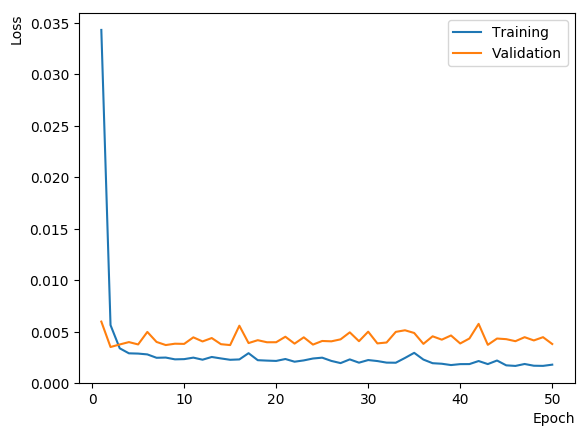

In [54]:
fig,ax = plt.subplots()

loss     = history.history['loss']
val_loss = history.history.get('val_loss')

x = range(1,len(loss)+1)
plt.plot(x,loss,    label='Training')
plt.plot(x,val_loss,label="Validation")

plt.xlabel('Epoch',ha='right',va='top',   position=(1,0))
plt.ylabel('Loss', ha='right',va='bottom',position=(0,1))

plt.legend(loc=0,numpoints=1)

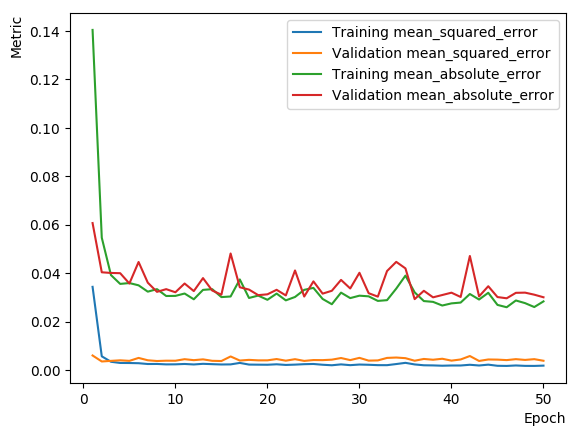

In [55]:
# Let's also plot the other metrics
# 'mse', 'mae', 'mape'
fig,ax = plt.subplots()

f_metrics = ['mean_squared_error', 'mean_absolute_error'] 
#, 'mean_absolute_percentage_error'] # scale off for mape

for metric in f_metrics:
    loss     = history.history[metric]
    val_loss = history.history.get('val_'+metric)

    x = range(1,len(loss)+1)
    plt.plot(x,loss,    label="Training "+metric)
    plt.plot(x,val_loss,label="Validation "+metric)

plt.xlabel('Epoch',ha='right',va='top',   position=(1,0))
plt.ylabel('Metric', ha='right',va='bottom',position=(0,1))

plt.legend(loc=0,numpoints=1)

In [0]:
predictions = model.predict(X_test_scale).flatten()  # convert the data back to the original scale
values      = np.divide((predictions - Y_test_scale.flatten()),Y_test_scale.flatten())        # offsets to compare predicted and actual value

Distribution = 0.013 $\pm$ 0.9179
EV Score     = 0.833


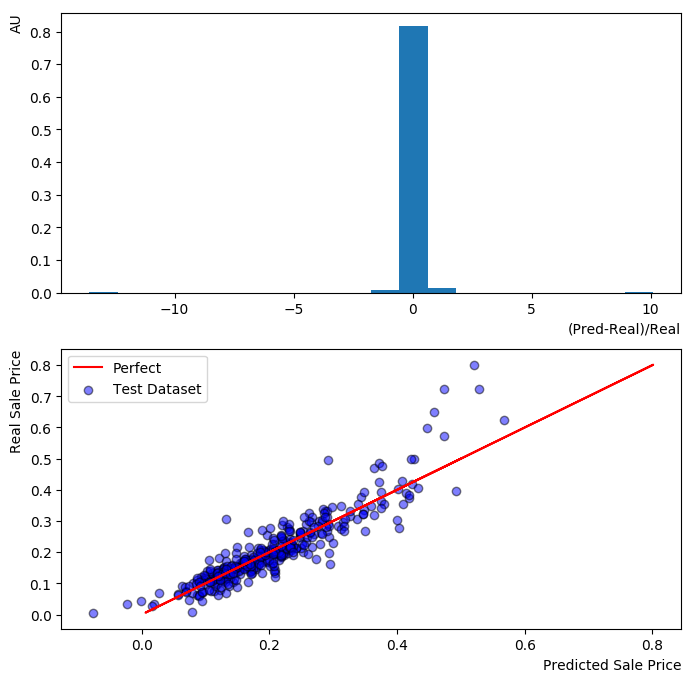

In [63]:
# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test_scale.flatten(),color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test_scale.flatten(),Y_test_scale.flatten(),color='r',label="Perfect")
# plt.xlim(min(predictions)-10000,max(predictions)+10000)
# plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test_scale.flatten(),predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

Distribution = 0.013 $\pm$ 0.1917
EV Score     = 0.833


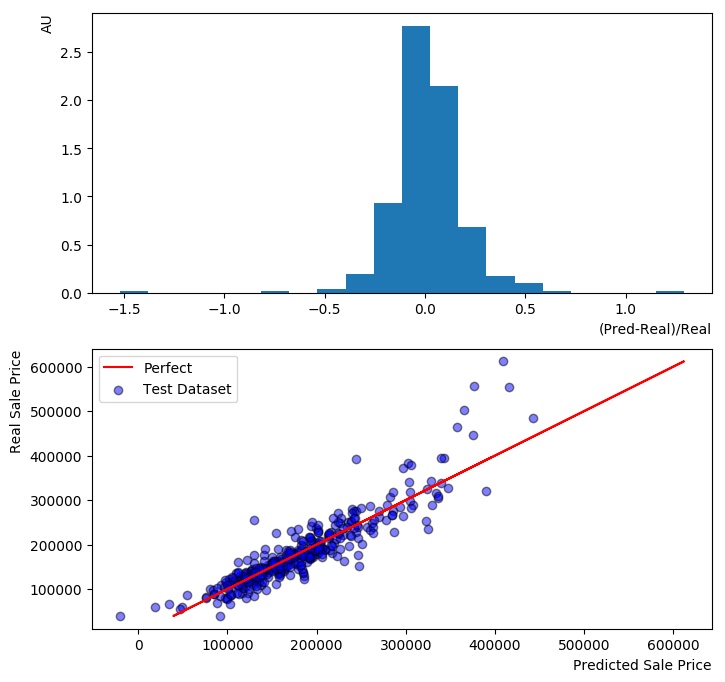

In [66]:
# Let's transform the target values back to the nominal scale and remake the plots
predictions = scaler_target.inverse_transform(model.predict(X_test_scale))  # convert the data back to the original scale
values      = np.divide((predictions.flatten() - Y_test),Y_test)        # offsets to compare predicted and actual value

# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
# plt.xlim(min(predictions)-10000,max(predictions)+10000)
# plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

After scaling the inputs, the performance is noticeably better -- which seems reasonable because now the weights are being updated by values on the same scale, and individual features aren't dominating the training.

#### Conclusions

Of course, there are _many_ hyperparameters that we can adjust to optimize performance and prevent overtraining.
With time, I'll revisit this to have a better idea as to what each parameter can affect.

After testing the different methods, it's easy to see how neural networks are more popular -- the great performance and easy-to-use API from `keras` creates a very low barrier to entry!

The next notebooks will tackle different datasets from Kaggle -- feel free to also check out the `Julia` notebooks (where I'm trying to learn the Julia language for data science).